<a href="https://colab.research.google.com/github/3x10e8/GrFNN-attention/blob/main/single_oscillator_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neurodynamics of Music
In this notebook, we will be implementing oscillator models from Large (2010) book chapter:

https://doi.org/10.1007/978-1-4419-6114-3_7

We'll be comparing a:
- linear bandpass filter (think Gammatone filterbanks for modeling a cochlea), with a 
- nonlinear oscillator (think one oscillator unit from Ed Large's GrFNNs)

Our goal is to see if either oscillator model can reproduce behavioral results from an attention study carried out by John Iversen et. al. (2008). In this study, participants were presented with a metronome-like sound stimulus and asked to tap along with the metronome. After an initial induction phase, a distractor metronome stimulus was introduced (in the other ear) to see test if the participants could keep the beat.

## Environment Setup

Required libraries:
- numpy
- scipy
- matplotlib
- IPython
- ipywidgets (for interactively changing oscillator parameters)
- time

In [1]:
# Uncomment and edit if you need to upgrade any packages:
# !pip3 install matplotlib --upgrade
# !pip3 install jupyter --upgrade

In [2]:
# import librosa # only needed if comparing beat tracking DSP
     
import numpy as np
from numpy import pi as π
from numpy import cos, sin, sqrt, exp

from scipy.signal import hilbert
from scipy.integrate import odeint

# should we use complex_ode?
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.complex_ode.html

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)
import inspect # this is for formatting figure titles with function code

import IPython
from IPython.display import Audio  # for audio playback
import ipywidgets  # for changing parameters interactively

import time  # for timing execution

Optional libraries
- import-ipynb (for sharing functions between notebooks)
- blackcellmagic (for code formatting)
- ipympl (for interactive plots within the notebook)

In [3]:
try:
    import import_ipynb
    import_stim = True
except ModuleNotFoundError:
    import_stim = False
    print('Skipping importing stimuli from separate notebook.')
    print('Could install this module using cell below.')

In [4]:
# Uncomment if you'd like to install import_ipynb, then run the previous cell again.
# !pip3 install import-ipynb

In [5]:
# import cell formatter, use by adding %%black to the cell to format
try:
    %load_ext blackcellmagic 
except ModuleNotFoundError:
    print("blackcellmagic not found!\n" \
          "This is only needed if you'd like to use black for cell formatting.\n" \
          "Can run the cell below if needed!")

In [6]:
# Uncomment if you'd like to install blackcellmagic, then run the previous cell again.
# !pip3 install blackcellmagic

In [7]:
# For interactive plotting inside the notebook
try:
    %matplotlib widget
except ModuleNotFoundError: # can just default to inline, or install ipympl using the next cell
    %matplotlib inline 
    print("ipympl not found!\n" \
          "This is only needed if you'd like more interactive plots in jupyter.\n" \
          "Can run the cell below if needed!")

In [8]:
# Uncomment to install ipyml if needed, and then rerun the previous cell!
# !pip3 install ipympl

## Helper Functions
$\color{red}{TODO}:$ This section could be moved to a separate python module/notebook and imported here.

### Plotting Utilities
Use the same plotting routine for consistent comparison across oscillator models.

In [9]:
FIG_L = 16
FIG_W = 8
# Helper plotter routine
def plotter(tt, x_input, psoln, fig=[], suptitle=""):
    """
    tt is a time array
    x_input is the lambda function used to generate input x(t) to the ode system
    psoln is the output of odeint, with
      r=psoln[:,1],
      φ=psoln[:,2]
    fig is a figure handle (needed if using widget-mode of matplotlib to prevent
        overwriting the same figure across cells)
    suptitle is a parameter string describing the model used. x_input will get appended before plotting.

    Input is plotted in red.
    """
    MY_DEFAULT_BLUE = (
        "#1f77b4"  # for coloring labels/axis using matplotlib's default blue
    )

    if fig == []:
        fig = plt.figure(figsize=(FIG_L, FIG_W))  # make a new figure
    
    # This is really just a proxy of the input for plotting, as the input is computed separately inside the odeint call
    xx = [x_input(t) for t in tt]

    # Convert input function code into a string for printing
    func_str = inspect.getsourcelines(x_input)[0][0].split('t: ')[-1]
    func_str = "+\n".join(func_str.split("+")) # break lines if its a long func
    suptitle += func_str
    
    # Plot input amplitude as a function of time
    ax1 = fig.add_subplot(321)
    ax1.plot(tt, np.abs(xx), 
             label="input", alpha=0.7, c=MY_DEFAULT_BLUE, linewidth=2)
    ax1.set_xlabel("time [s]")
    ax1.set_ylabel("Input Amplitude $||x(t)||$", color=MY_DEFAULT_BLUE)
    ax1.tick_params(axis="y", labelcolor=MY_DEFAULT_BLUE)
    #ax1.legend("upper left")
    ax1.set_title("Input | Output Amplitude")
    """
    # Plot input in phase plane
    ax1.plot(np.real(xx), np.imag(xx))
    ax1.set_xlabel('$Re\{Fe^{jθ}\}$')
    ax1.set_ylabel('$Im\{Fe^{jθ}\}$')
    ax1.axis('equal')
    """

    # Plot oscillator amplitude as a function of time
    ax1r = ax1.twinx()
    ax1r.plot(tt, psoln[:, 0], label="output", c="r")
    ax1r.set_ylabel("Output Amplitude $r$", color="r")
    ax1r.tick_params(axis="y", labelcolor="r")
    #ax1r.legend("upper right")
    #plt.grid(True)

    # Plot input phase as a function of time
    ax2 = fig.add_subplot(323)
    ax2.plot(tt, (np.angle(xx) % (2 * π)) * 180 / π, 
             label="input", alpha=0.7, c=MY_DEFAULT_BLUE, linewidth=3)
    ax2.set_xlabel("time [s]")
    ax2.set_ylabel("Input Phase θ [deg]", color=MY_DEFAULT_BLUE)
    ax2.tick_params(axis="y", labelcolor=MY_DEFAULT_BLUE)
    ax2.set_title("Input | Output Phase")
    ax2.set_ylim(0, 360)
    #ax2.legend("upper left")

    # Plot oscillator phase as a function of time
    ax2r = ax2.twinx()
    ax2r.plot(tt, (psoln[:, 1] % (2 * π)) * 180 / π, 
             label = "output", c="r")
    ax2r.set_ylabel("Output Phase φ [deg]", color="r")
    ax2r.tick_params(axis="y", labelcolor="r")
    ax2r.set_ylim(0, 360)
    plt.grid(True)
    #ax2r.legend("upper right")

    # Extract the I/Q outputs as representing each coupled oscillator
    z = psoln[:, 0] * exp(1j * psoln[:, 1])
    Re_z = np.real(z)
    Im_z = np.imag(z)

    # Plot the I/Q waveforms over time
    ax3 = fig.add_subplot(325)
    ax3.plot(tt, Re_z, label="$Re\{z\}$", alpha=0.5, c="green")
    ax3.plot(tt, Im_z, label="$Im\{z\}$", alpha=0.5, c="grey")
    ax3.set_xlabel("time [s]")
    ax3.set_ylabel("Amplitude")
    ax3.set_title("Coupled Oscillator Outputs")
    ax3.legend(loc="upper right")
    plt.grid(True)

    # Plot the complex state variable z
    axO = fig.add_subplot(122)
    axO.plot(Re_z, Im_z, alpha=0.75, c="r")
    axO.set_xlabel("$Real\{z\}$", c="green")
    axO.set_ylabel("$Imag\{z\}$", c="grey")
    # center axes:
    axO.spines["top"].set_color("none")
    axO.spines["right"].set_color("none")
    axO.spines["bottom"].set_position("zero")
    axO.spines["left"].set_position("zero")
    axO.spines["bottom"].set_color("green")
    axO.spines["left"].set_color("grey")
    axO.axis("equal")

    axO.set_title(suptitle)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # https://www.geeksforgeeks.org/how-to-put-the-origin-in-the-center-of-the-figure-with-matplotlib/

### Stimulus Envelope Extraction
We want our oscillator model to replicate behavioral results collected by Iversen et. al. (John). So we use the same audio stimuli as used in John's experiment, except we add some processing to extract only impulses/onsets from these metronome-like stimuli. 

The envelope of a modulated signal $s(t)$ can be extracted using the Hilbert transform:

(https://en.wikipedia.org/wiki/Analytic_signal)

$s_{a}(t) = s(t) + j\hat{s}(t)$, where $\hat{s}(t)$ represents the Hilbert transform of $s(t)$.

The analytical signal $s_a(t)$ can be written as:

$s_{a}(t) = s_{m}(t)e^{j\theta(t)}$, where $s_m(t)$ is the _envelope_.

$\Rightarrow s_{m}(t) = \left\| s_{a}(t) \right\| = \left\|s(t) + j\hat{s}(t)\right\|$

In python/matlab, it looks like the ```hilbert``` function outputs the analytic signal:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

$x_{analytic} = $ `hilbert` $[x(t)]$ \
$x_{envelope} = \left\| x_{analytic} \right\|$

In [10]:
# Envelope extraction using the Hilbert transform
def extract_onsets(data, ϵ=1):
    """
    Takes the Hilbert transform to extract the envelope
    Removes any DC bias
    Normalizes the signal to be in [-1, 1]
    Scales by dividing by ϵ
    """
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)  # gives the envelope
    # amplitude_envelope -= np.mean(amplitude_envelope) # remove DC
    # amplitude_envelope /= max(np.abs(amplitude_envelope)) # normalize
    # amplitude_envelope /= sqrt(ϵ)
    return amplitude_envelope

# Linear Bandpass Filter
We begin with the simplest oscillator model from Large (2010), which can be thought of as a linear damper:

$$\dot{z} = z(α+iω) + x(t)$$

with parameters as described below:

parameter|description
----|----
$z$ | complex valued state variable 
$α < 0$ | linear dampling
$ω = 2πf$ | radial frequency
$x(t)$ | time-varying external input (linear forcing) 

We first go from one complex ODE in $z$ to two equations (in the oscillation's amptitude $r$ and phase $\phi$). We could have just used $z$ but I am not sure how to correctly configure scipy's odeint for handling integration of complex variables.

Substituting $z = r e^{iϕ}$ and $x = Fe^{iθ}$ (nomenclature from Large-Almonte-Velasco 2010):

$$
\begin{align}
\dot{\color{magenta}{z}} &= \color{magenta}{z}(α+iω) + x(t) \\
⇒ \dot{\left( \color{magenta}{ r e^{iϕ} }\right)} 
&= \color{magenta}{ r e^{iϕ} }(α+iω) + Fe^{iθ} \\
⇒ \color{red}{e^{iϕ}} \left( \dot{r}  + ir\dot{ϕ} \right) 
&= r \color{red}{e^{iϕ}} (α+iω) + Fe^{iθ} \\
⇒ \dot{r}  + ir\dot{ϕ}
&= r(α+iω) + F \color{green}{e^{iθ}} \\
⇒ \dot{r}  + ir\dot{ϕ}
&= r(α+iω) + F (\color{green}{cosθ + isinθ}) \\
⇒ \color{blue}{\dot{r}}  + i \color{orange}{r\dot{ϕ}}
&= \color{blue}{rα + Fcosθ} +i \color{orange}{(rω + Fsinθ)} \\
⇒ \begin{cases}
\color{blue}{\dot{r}} &= \color{blue}{rα + Fcosθ} \\
\color{orange}{\dot{ϕ}} &= \color{orange}{ω + \frac{F}{r}sinθ} \\
\end{cases}
\end{align}
$$

### Fixed Points
$\color{red}{TODO}:$ How do we use this for deciding stable input regimes for $F$?

$$\dot{r}=0=rα + Fcosθ$$

Under unforced conditions ($F=0$):

$$
\dot{r}=0=rα \\
⇒ r = 0
$$
is the only fixed point (assuming $α\neq0$, which is acceptable as $α<0$ for damping.)

$$
\dot{ϕ} = 0 = ω + \frac{F}{r}sinθ
$$
Again, under $F=0$:
$$
\dot{ϕ} = 0 = ω \\
⇒ ω=0
$$




### Define this oscillator as an $f$ to be called by odeint

In [11]:
# ODE system for a linear bandpass filter
def f_linear(y, t, params):
    """
    This is the general ODE template we would use.

    Inputs:
      y: [list of state variables],
      t: a single time stamp, as provided by odeint
      params: any ODE parameters, followed by
        xx: an array of input/stimulus, and a
        fs: sampleing rate

    Returns:
      function returns a list of derivatives for each state variable in y.
    """
    r, ϕ = y
    α, ω, sig_gen = params

    sample = sig_gen(t)
    F = np.abs(sample)
    θ = np.angle(sample)  # calculate the new input

    drdt = r * α + F * cos(θ)
    dϕdt = ω + (F / r) * sin(θ)

    derivs = [drdt, dϕdt]

    return derivs

### Parameter exploration
$\color{red}{Warning!}$

Below code runs into numerical errors if the driving input's frequency $ω_{ext} > 0.17$, given the oscillator's intrinsic $ω=1$.

Eyeballing the plots looks like bringing $ω_{ext} → ω$ causes $ϕ$ to spin too fast, causing the integration to break down?

One workaround seems to be to add noise on top of the external input $F + rand()$, but not sure how realistic that is, and it makes the code take about 2 minutes to execute...

For faster execution try smaller $ω_{ext} < 0.17$

In [12]:
@ipywidgets.interact(α=(-3.0, 3.0), ω=(-3.0, 3.0), F=(-5.0, 5.0), ω_ext=(-3.0, 3.0))
def solve(α=-1, ω=1, F=0.5, ω_ext=0.17):  # Call the ODE solver

    # Initial conditions
    r0 = 1
    φ0 = 0
    y0 = [r0, φ0]

    # Make time array for solution
    t1 = 10  # stop time
    dt = 1e-3
    tt = np.arange(0.0, t1, dt)

    # sinusoidal input
    x_input = lambda t: F * exp(1j * ω_ext * t)

    params = [α, ω, x_input]

    # Call the ODE solver
    START_TIME = time.time()  # for timing execution
    debug = not True
    if debug:
        psoln = odeint(f_linear, y0, tt, args=(params,), mxstep=5000000, full_output=1)
        print(psoln)
    else:
        psoln = odeint(
            f_linear,
            y0,
            tt,
            args=(params,),
            mxstep=5000000,
            # rtol=1e-15,
            # atol=1e-15,
            # full_output=1,
        )

    print("Done in {:.2f}s".format(time.time() - START_TIME))
    
    # Plot results
    fig_lin = plt.figure(figsize=(FIG_L, FIG_W))
    suptitle = "$\dot{z}$ = $z$(" + "{}+$i${}) + ".format(α, ω)
    plotter(tt, x_input, psoln, fig_lin, suptitle)

interactive(children=(FloatSlider(value=-1.0, description='α', max=3.0, min=-3.0), FloatSlider(value=1.0, desc…

# Large-Almonte-Velasco Oscillator Model (2010)
Equations 16 and 17 from the 2010 paper:

$$ \dot{r} = 
r \left( 
  α 
  + β_1 r^2  
  + \frac{β_2ϵ r^4}{1 − ϵ r^2}
\right)
+ \frac{\color{red}{F}(ϵFr + cos(φ − θ)) − \sqrt{ϵ}(F cosφ + rcosθ)}{(1 + ϵ F^2 − 2F \sqrt{ϵ} cos θ )(1 + ϵ r^2 − 2r\sqrt{ϵ} cosφ)} $$

$$ \dot{φ} = ω 
+ δ_1 r^2 
+ \frac{δ_2ϵ r^4}{1 − ϵ r^2} 
+ \frac{F (sin(θ − φ) + \sqrt{ϵ}(F sin φ − r sin θ))}{(1 + ϵ F^2 − 2F \sqrt{ϵ} cosθ)(1 + ϵ r^2 − 2r \sqrt{ϵ} cosφ)r} $$

How do we set these parameter values?

In [13]:
# https://physics.nyu.edu/pine/pymanual/html/chap9/chap9_scipy.html
def f(z, t, params):
    r, φ = z  # unpack current values of z
    α, ω, β_1, δ_1, β_2, δ_2, ϵ, sig_gen = params  # unpack parameters

    # Update the input x(t)
    sample = sig_gen(t)
    F = np.abs(sample)
    θ = np.angle(sample)

    # Expressions for derivatives
    drdt = α
    drdt += β_1 * (r ** 2)
    drdt += (β_2 * ϵ * (r ** 4)) / (1 - (ϵ * (r ** 2)))
    drdt *= r

    Nr = (ϵ * F * r + cos(φ - θ))
    Nr -= sqrt(ϵ) * (F * cos(φ) + r * cos(θ))
    Nr *= F # updated F multiplication 11/12/22 -- needs to be verified
    Dr = 1 + ϵ * (F ** 2) - 2 * F * sqrt(ϵ) * cos(θ)
    Dr *= 1 + ϵ * (r ** 2) - 2 * r * sqrt(ϵ) * cos(φ)
    drdt += Nr / Dr

    dφdt = ω
    dφdt += δ_1 * (r ** 2)
    dφdt += (δ_2 * ϵ * (r ** 4)) / (1 - ϵ * (r ** 2))
    Nrφ = (sin(θ - φ)) # fixed F multiplication error 11/9/22
    Nrφ += sqrt(ϵ) * (F * sin(φ) - r * sin(θ))
    Nrφ *= F
    Drφ = Dr * r  # same denominator as above except a factor of r
    # dφdt += Nrφ / Drφ

    derivs = [drdt, dφdt]  # list of dy/dt=f functions

    return derivs

## Zero Input Condition
Parameter | Value
---|---
x(t) | 0
ω | 1/T

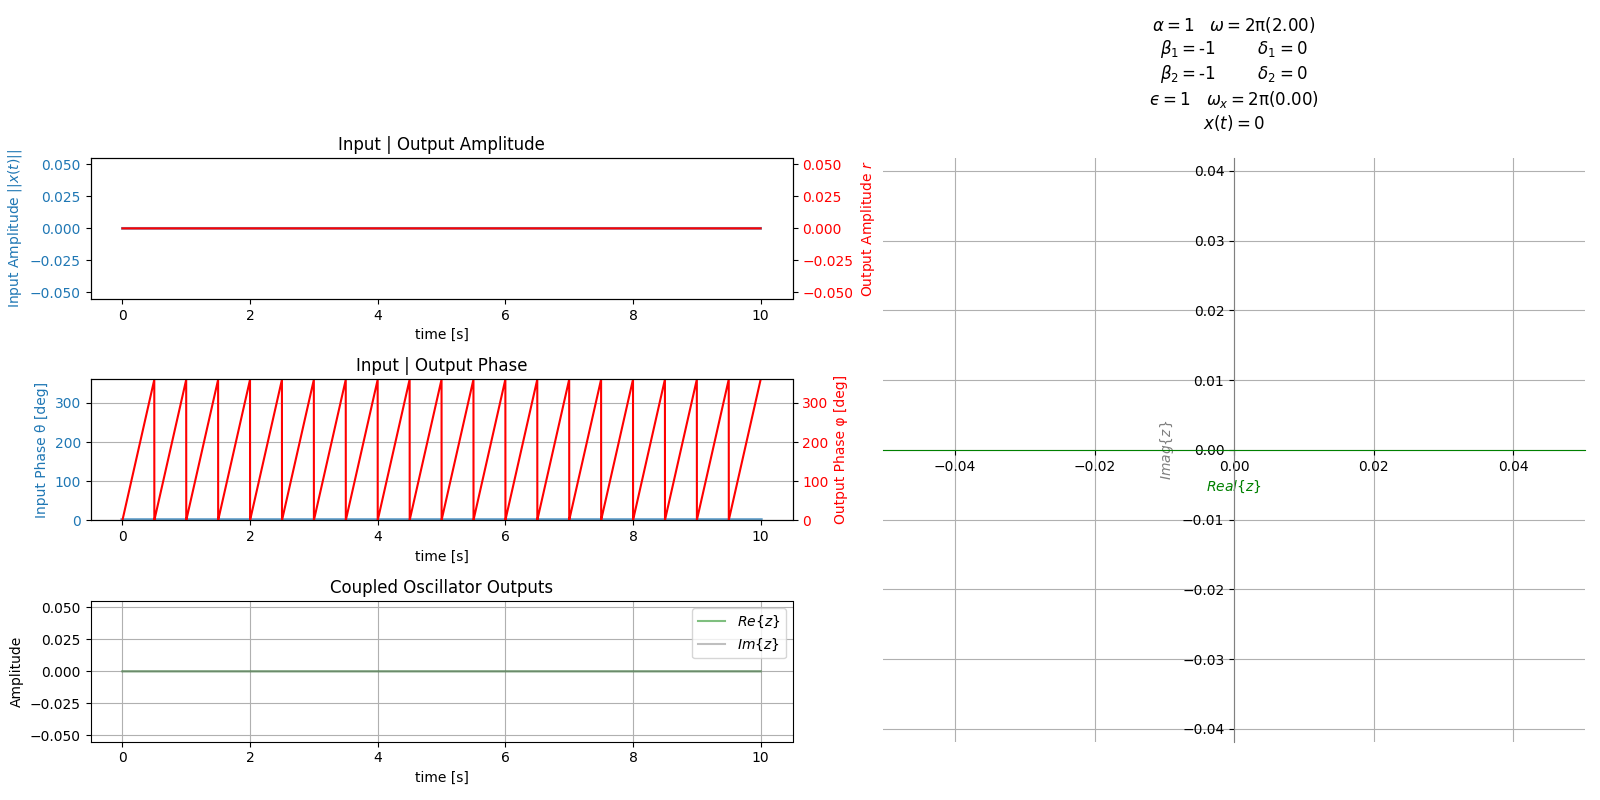

In [21]:
# State vaiables
## [r, φ]

# Pick a period to set the natural frequency for the oscillators
T_natural_s = 0.5

# Make time array for solution
t1 = 10  # stop time
dt = 1e-3
fs = 1/dt
tt = np.arange(0.0, t1, dt)

# Initial conditions
r0 = 0  # keep this small, see integration errors >= 1
φ0 = 0

# Parameters
## a
α = 1
ω = 2 * π * (1/T_natural_s)  # trying a 120bpm (2Hz) natural freq

## b
β_1 = -1
δ_1 = 0  # 1

## d
β_2 = -1
δ_2 = 0  # 1

ϵ = 1  # closeness

# Select input stimulus
## Zeros
ω_x = 0
x_input = lambda t: 0

params = [α, ω, β_1, δ_1, β_2, δ_2, ϵ, x_input]
z0 = [r0, φ0]

# Call the ODE solver
psoln = odeint(
    f, 
    z0, 
    tt, 
    args=(params,), 
    # mxstep=5000000,
)

# Plot results
fig_grfnn = plt.figure(figsize=(FIG_L, FIG_W))
suptitle =  "$α=${}\t$ω=$2π({:.2f})\n"\
            "$β_1=${}\t$δ_1=${}\n"\
            "$β_2=${}\t$δ_2=${}\n"\
            "$ϵ=${}\t$ω_x=$2π({:.2f})\n"\
            "$x(t)=$".format(
                α, ω/2/π, β_1, δ_1, β_2, δ_2, ϵ, ω_x/2/π)
plotter(tt, x_input, psoln, fig_grfnn, suptitle)

## Zero phase ramp
Parameter | Value
---|---
$x(t)$ | $\frac{t}{duration}$
$ω$ | $\frac{1}{T}$

Done in 0.13s


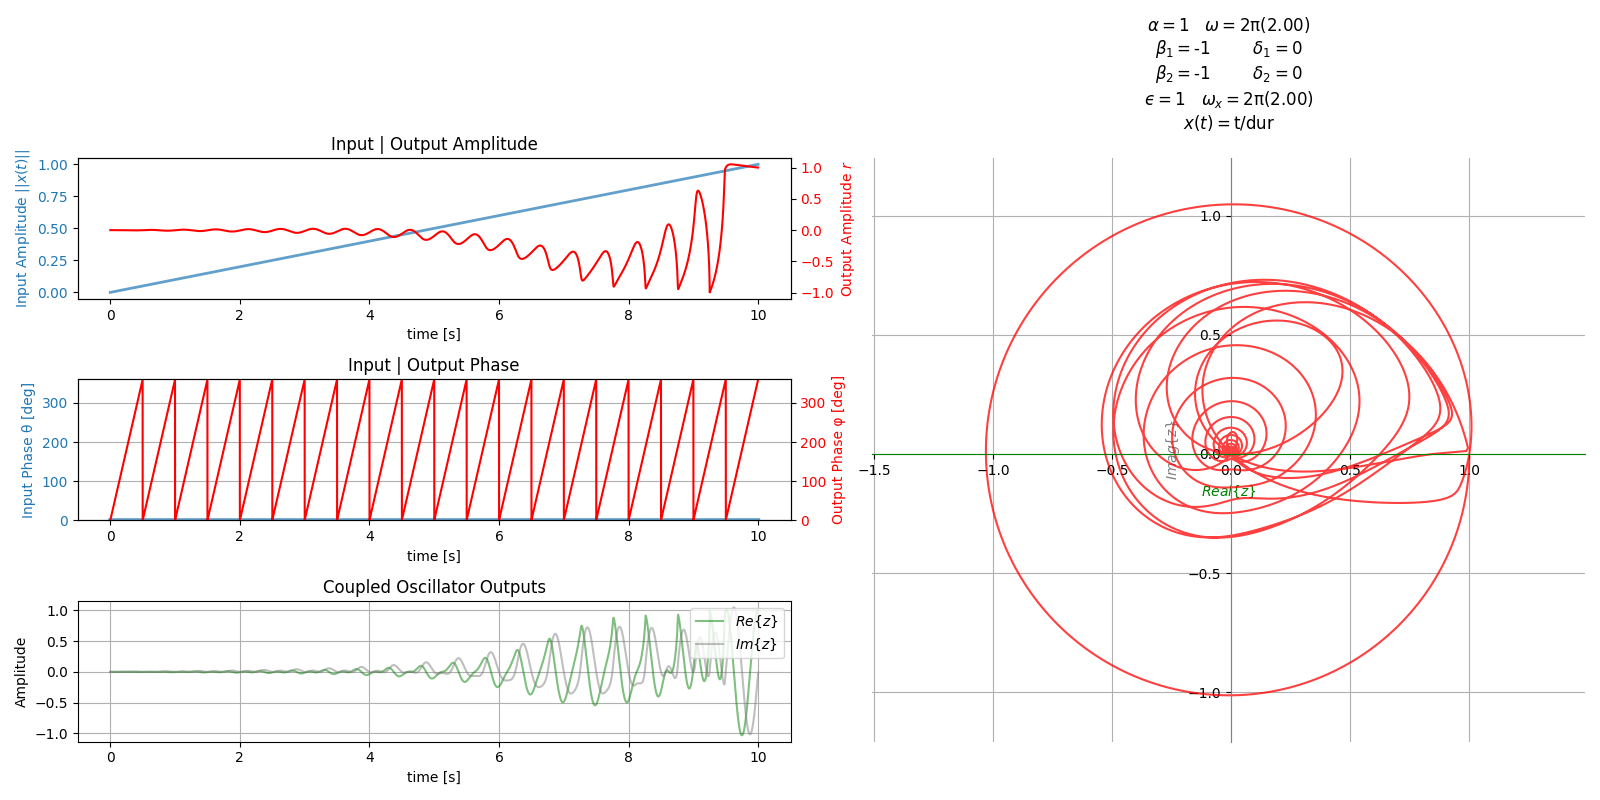

In [22]:
# Update input function
## CW stimulus
ω_x = 2 * π * (1 / T_natural_s)
dur = len(tt)/fs
x_input = lambda t: t/dur
# need to keep amplitude <1 for integration to converge...

# Update params
params = [α, ω, β_1, δ_1, β_2, δ_2, ϵ, x_input]

# Call the ODE solver
START_TIME = time.time()  # for timing execution
psoln = odeint(
    f,
    z0,
    tt,
    args=(params,),
    mxstep=5000000,
)

print("Done in {:.2f}s".format(time.time() - START_TIME))

# Plot results
fig_grfnn_cw = plt.figure(figsize=(FIG_L, FIG_W))
suptitle =  "$α=${}\t$ω=$2π({:.2f})\n"\
            "$β_1=${}\t$δ_1=${}\n"\
            "$β_2=${}\t$δ_2=${}\n"\
            "$ϵ=${}\t$ω_x=$2π({:.2f})\n"\
            "$x(t)=$".format(
                α, ω/2/π, β_1, δ_1, β_2, δ_2, ϵ, ω_x/2/π)
plotter(tt, x_input, psoln, fig_grfnn_cw, suptitle)

## Ramp with synchronous phase
Parameter | Value
---|---
$x(t)$ | $\frac{t}{duration} e^{i \frac{2π}{T} t}$
$ω$ | $\frac{1}{T}$

Done in 0.11s


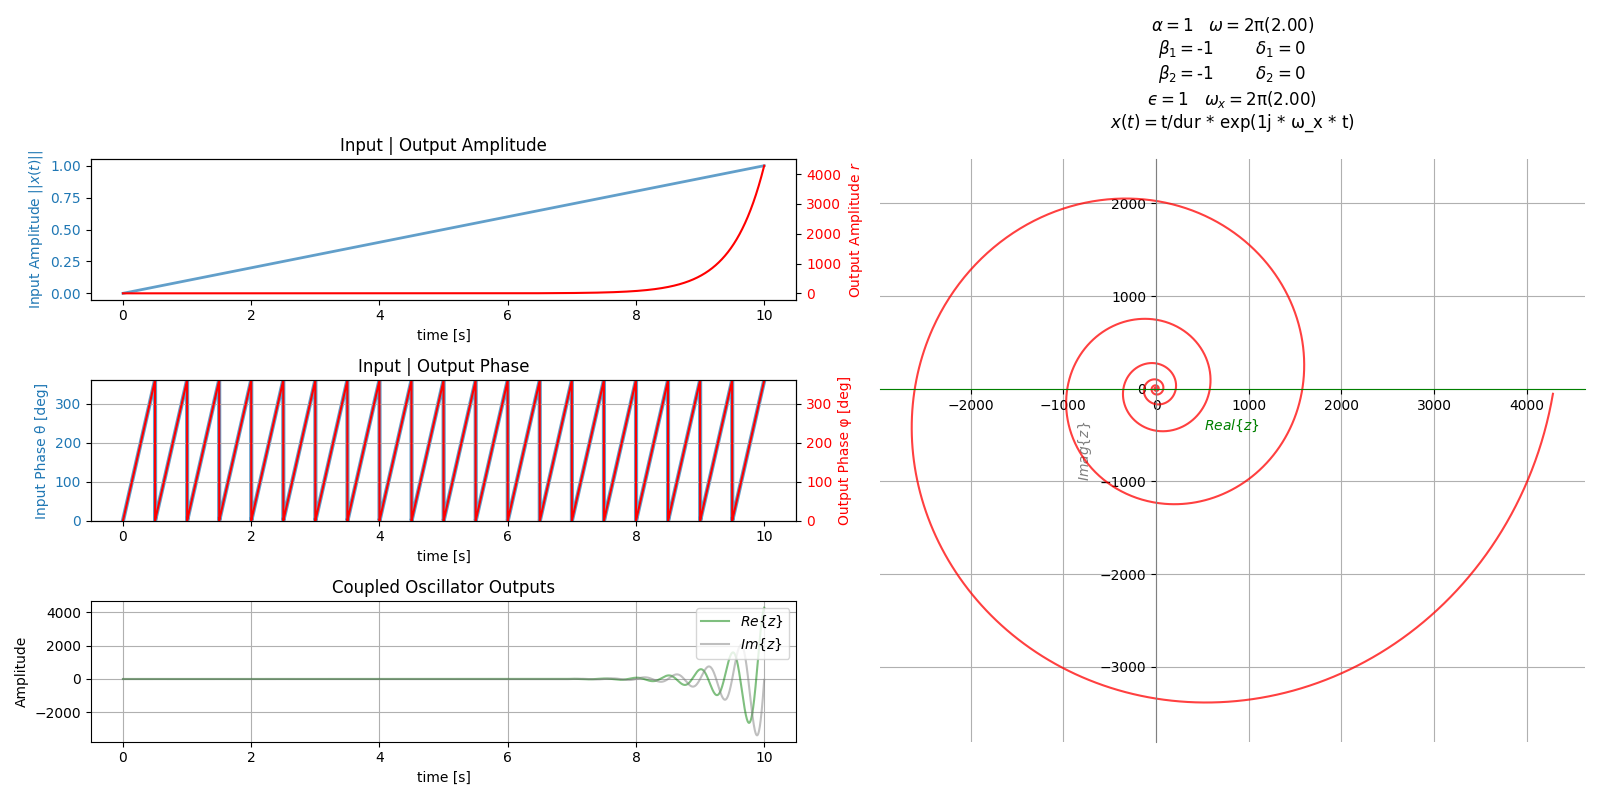

In [24]:
# Update input function
## CW stimulus
ω_x = 2 * π * (1 / T_natural_s)
dur = len(tt)/fs
x_input = lambda t: t/dur * exp(1j * ω_x * t)
# need to keep amplitude <1 for integration to converge...

# Update params
params = [α, ω, β_1, δ_1, β_2, δ_2, ϵ, x_input]

# Call the ODE solver
START_TIME = time.time()  # for timing execution
psoln = odeint(
    f,
    z0,
    tt,
    args=(params,),
    mxstep=5000000,
)

print("Done in {:.2f}s".format(time.time() - START_TIME))

# Plot results
fig_grfnn_cw = plt.figure(figsize=(FIG_L, FIG_W))
suptitle =  "$α=${}\t$ω=$2π({:.2f})\n"\
            "$β_1=${}\t$δ_1=${}\n"\
            "$β_2=${}\t$δ_2=${}\n"\
            "$ϵ=${}\t$ω_x=$2π({:.2f})\n"\
            "$x(t)=$".format(
                α, ω/2/π, β_1, δ_1, β_2, δ_2, ϵ, ω_x/2/π)
plotter(tt, x_input, psoln, fig_grfnn_cw, suptitle)

## Complex Sin Input


Done in 0.17s


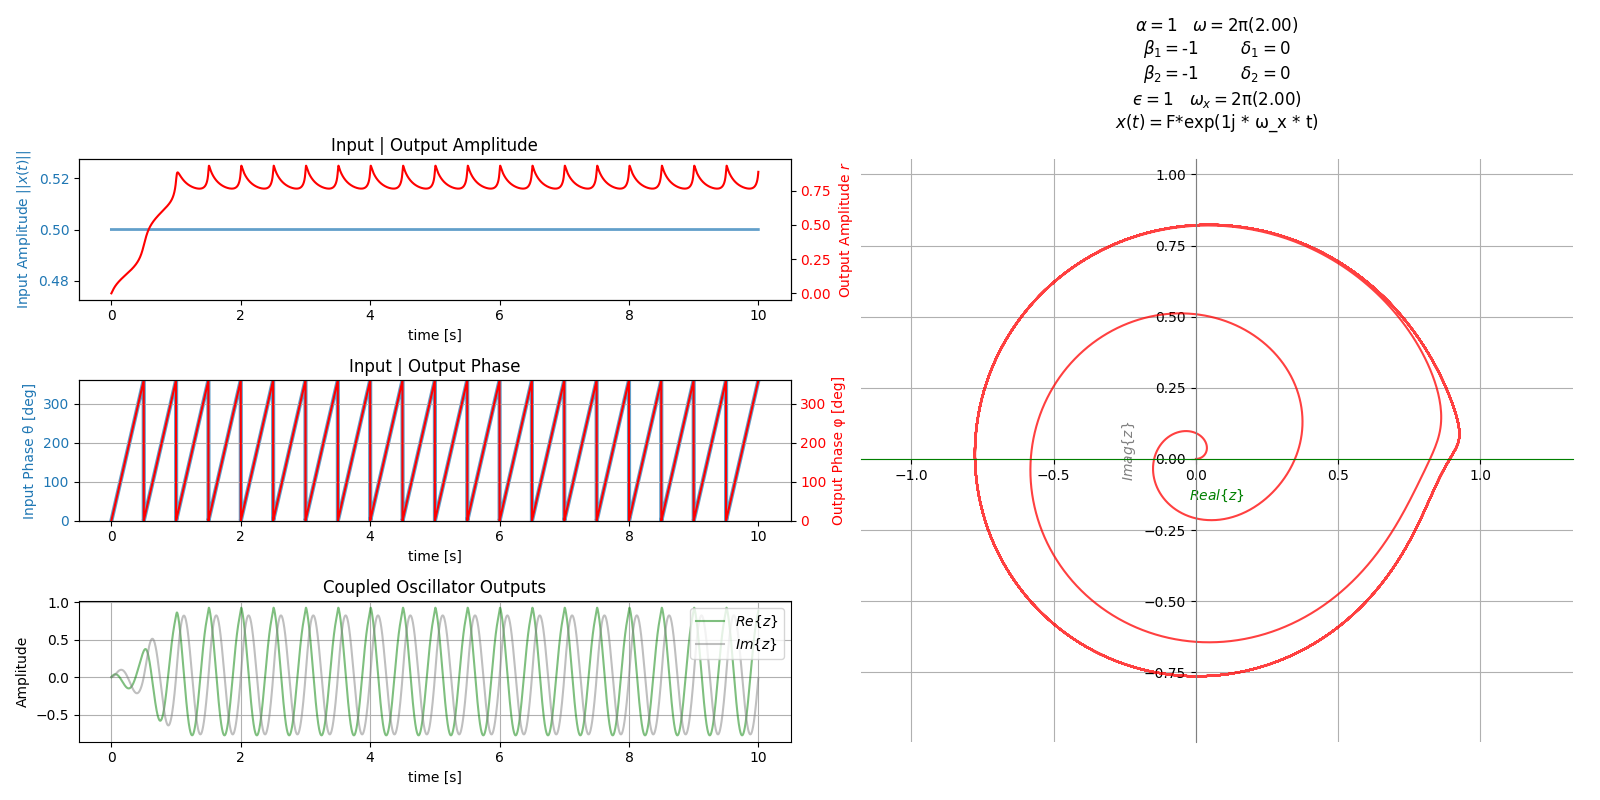

In [26]:
# Update input function
## CW stimulus
ω_x = 2 * π * (1 / T_natural_s)
dur = len(tt)/fs
F = 0.5
x_input = lambda t: F*exp(1j * ω_x * t)
# need to keep amplitude <1 for integration to converge...

# Update params
params = [α, ω, β_1, δ_1, β_2, δ_2, ϵ, x_input]

# Call the ODE solver
START_TIME = time.time()  # for timing execution
psoln = odeint(
    f,
    z0,
    tt,
    args=(params,),
    mxstep=5000000,
)

print("Done in {:.2f}s".format(time.time() - START_TIME))

# Plot results
fig_grfnn_cw = plt.figure(figsize=(FIG_L, FIG_W))
suptitle =  "$α=${}\t$ω=$2π({:.2f})\n"\
            "$β_1=${}\t$δ_1=${}\n"\
            "$β_2=${}\t$δ_2=${}\n"\
            "$ϵ=${}\t$ω_x=$2π({:.2f})\n"\
            "$x(t)=$".format(
                α, ω/2/π, β_1, δ_1, β_2, δ_2, ϵ, ω_x/2/π)
plotter(tt, x_input, psoln, fig_grfnn_cw, suptitle)